# Who is heading for Diabetes?

This is the predictive part of the 2017 Melbourne Datathon.

The task is to predict the probability that a patient will be dispensed a drug related to Diabetes post 2015. This is quite important research as it will be an early warning system for doctors so intervention can potentially be made before it is too late.

Use the patients that we have provided all the records for to build your model, then see how it performs on these unseen people.

For patient ID'S 279,201 to 558,352 you need to submit a file with 2 columns, the Patient_ID and the probability in the range [0-1]. The file will have 279,153 rows including the header row. An example submission file is provided for download.

In [1]:
import tqdm

import pandas as pd
import numpy as np
import pickle
import sqlite3
import xgboost

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import normalize, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

%matplotlib inline

C:\Users\Nathan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data retrieval functions

In [2]:
conn = sqlite3.connect("../data/datasets.db")

In [3]:
def fast_retrieve_patient_data(connection, patient_id):
    SQL = """
SELECT *
FROM transaction_merge
WHERE Patient_ID = {}
""".format(patient_id)
    return pd.read_sql_query(SQL, connection)


def retrieve_patient_data(connection, patient_id):
    """
    Return the patient data.
    """
    SQL = """
SELECT *
FROM transactions a
LEFT OUTER JOIN ChronicIllness_LookUp b 
    ON a.Drug_ID = b.MasterProductID 
LEFT OUTER JOIN patients c
    ON a.Patient_ID = c.Patient_ID
LEFT OUTER JOIN classification d
    ON a.Patient_ID = d.Patient_ID
LEFT OUTER JOIN social e
    ON c.postcode = e.postcode
WHERE a.Patient_ID = {}
AND a.prescription_week < '2016-01-01'
    """.format(patient_id)

    return pd.read_sql_query(SQL, connection)


def retrieve_chronic_illness(connection):
    SQL = """
SELECT DISTINCT ChronicIllness FROM ChronicIllness_LookUp 
    """
    return pd.read_sql_query(SQL, connection)
    
def retrieve_system_codes(connection):
    SQL = """
SELECT DISTINCT SourceSystem_Code FROM transactions 
    """
    return pd.read_sql_query(SQL, connection)
    

def retrieve_prescriber_id(connection):
    SQL = """
SELECT DISTINCT Prescriber_ID FROM transactions 
    """
    return pd.read_sql_query(SQL, connection)

## Feature extraction functions

In [25]:
gender_map = {'F': 1, 'M': 0, 'U': 0.5}

def number_of_prescribers(patient_frame):
    return patient_frame.Prescriber_ID.unique().shape[0]

def gender(patient_frame):
    return gender_map[patient_frame.gender[0]]

def age(patient_frame):
    patient_age = 2016 - patient_frame.year_of_birth[0]
    if patient_age > 100: 
        return 0.5 
    else: 
        return patient_age / 100.

def age_ranges(patient_frame):
    patient_age = 2016 - patient_frame.year_of_birth[0]
    return {'age_0_18': 1.0 if (0 > patient_age < 18) else 0.,
            'age_35_55': 1.0 if (35 > patient_age < 55) else 0.,
            'age_55_70': 1.0 if (55 > patient_age < 70) else 0.,
            'age_70_100': 1.0 if (70 > patient_age < 100) else 0.}
    
def socio_score(patient_frame):
    score = patient_frame.disadvantage_score[0]
    if isinstance(score, str):
        return 1.
    if score is None:
        return 1.
    return float(score) / 1000.

def diabetes(patient_frame):
    return float(patient_frame.ChronicIllness.str.contains('Diabetes').any())

def mean_script_time(patient_frame):
    script_week_diff = pd.to_datetime(patient_frame.Prescription_Week).diff()
    return script_week_diff[script_week_diff > pd.Timedelta(0)].mean() / pd.Timedelta(days=365*6)

def system_codes(patient_frame):
    codes = {'F':0, 'Z':0, 'C':0, 'A':0, 'L':0, 'M':0, 'P':0}
    codes.update(patient_frame.SourceSystem_Code.value_counts(normalize=True).to_dict())
    return {'system_code_' + x.lower():y for x,y in codes.items()}

def chronic_illness(patient_frame):
    chronic_treatments = {
     'Anti-Coagulant': 0,
     'Chronic Obstructive Pulmonary Disease (COPD)': 0,
     'ChronicIllness': 0,
     'Depression': 0,
     'Diabetes': 0,
     'Epilepsy': 0,
     'Heart Failure': 0,
     'Hypertension': 0,
     'Immunology': 0,
     'Lipids': 0,
     'Osteoporosis': 0,
     'Urology': 0}
    
    chronic_treatments.update(patient_frame.ChronicIllness.value_counts(normalize=True).to_dict())
    chronic_treatments.pop('ChronicIllness')
    return {'illness_' + x.lower().replace(' ', '_'):y for x,y in chronic_treatments.items()}
    

## Compute some basic features of the data 

In [26]:
def feature_extract(patient_frame):
    """
    Form a feature dictionary
    """
    
    feature_dict = {
        'gender': gender(patient_frame), 
        'age': age(patient_frame), 
        'socio_score': socio_score(patient_frame),
        'mean_script_time': mean_script_time(patient_frame),
        'prescriber_count': number_of_prescribers(patient_frame),
        'target': patient_frame.Target[0]}
    
    feature_dict.update(system_codes(patient_frame))
    feature_dict.update(chronic_illness(patient_frame)) 
    feature_dict.update(age_ranges(patient_frame))
    
    return feature_dict
    

## Extract features of the data

Perform a random sample of patients.

In [75]:
n = 100000
patient_ids = np.random.randint(0, 279201, n)
patient_data = []
for patient_id in tqdm.tqdm_notebook(patient_ids):
    patient_data.append(fast_retrieve_patient_data(conn, patient_id))

80394/|/ 80%|| 80394/100000 [16:28<04:01, 81.29it/s]                                                 


Extract features into a feature dataframe.

In [76]:
features = []
for patient in tqdm.tqdm_notebook(patient_data): 
    if len(patient):
        features.append(feature_extract(patient))
feature_frame = pd.DataFrame(features)

13536/|/ 14%|| 13536/100000 [03:50<24:33, 58.69it/s]                                                 

KeyboardInterrupt: 

19748/|/ 20%|| 19748/100000 [05:10<21:02, 63.56it/s]                                                 

Store the features and ?patient data? to disk.

In [ ]:
feature_frame.to_csv('../submissions/features.csv')

with open('../submissions/patient_data.pkl', 'wb') as fh:
    pickle.dump(patient_data, fh)

In [6]:
# feature_frame = pd.read_csv('../submissions/features.csv')

# with open('../submissions/patient_data.pkl', 'rb') as fh:
#     patient_data = pickle.load(fh)

## Explore the feature we have extracted

Note: not sure here - trying out something from scikit learn but it may not be sensible.

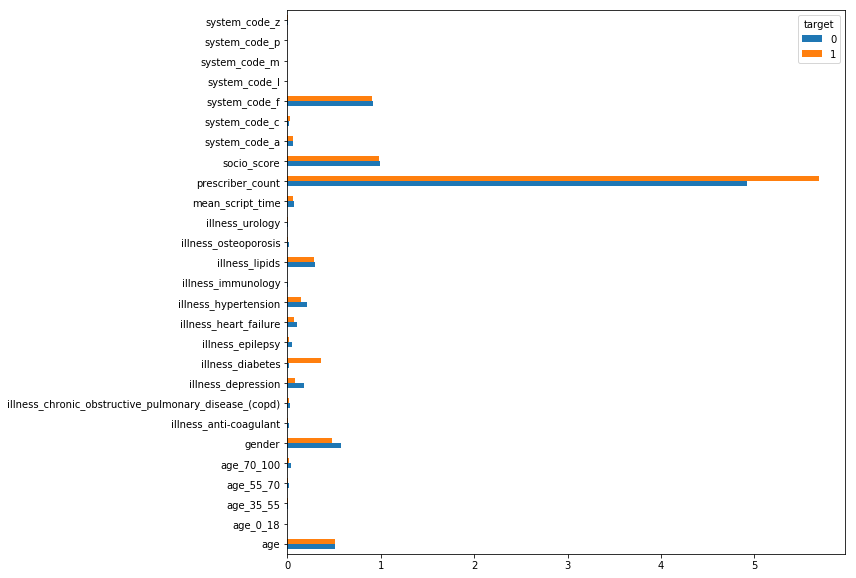

In [35]:
means = feature_frame.groupby('target').mean().T
means.plot(kind='barh', figsize=(10,10))

## Try out a set of different classifiers

Note: the feature matrix is usually transformed to have zero mean and unit standard deviation.

In [29]:
X = feature_frame.drop('target', axis=1).values
y = feature_frame.target.values

X_transformed = StandardScaler().fit_transform(X)

Partition the data into test and train datasets.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.5, random_state=0)

In [44]:
classifiers = [
    ('Random Forrest', RandomForestClassifier()),
    ('SVM',SVC(probability=True, class_weight='balanced')),
    ('Gradient boosted decition tree', xgboost.XGBClassifier())]

for name, clf in classifiers:
    print('Classifier: {}'.format(name))
    model = clf.fit(X_train, y_train)
    y_true, y_pred = y_test, model.predict(X_test) 
    print(classification_report(y_true, y_pred))


Classifier: Random Forrest
             precision    recall  f1-score   support

          0       0.96      0.96      0.96      4064
          1       0.84      0.81      0.83       936

avg / total       0.94      0.94      0.94      5000

Classifier: SVM
             precision    recall  f1-score   support

          0       0.97      0.96      0.96      4064
          1       0.82      0.87      0.85       936

avg / total       0.94      0.94      0.94      5000

Classifier: Gradient boosted decition tree
             precision    recall  f1-score   support

          0       0.98      0.96      0.97      4064
          1       0.83      0.92      0.87       936

avg / total       0.95      0.95      0.95      5000



In [74]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    ('Random Forrest', RandomForestClassifier(n_estimators=100)),
    ('SVM',SVC(probability=True, class_weight='balanced')),
    ('Gradient boosted decition tree', xgboost.XGBClassifier())]
 
    
clf = VotingClassifier(classifiers, voting='soft', weights=[0.2, 0.1, 0.7])
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test) 

print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.96      0.97      4064
          1       0.84      0.89      0.86       936

avg / total       0.95      0.95      0.95      5000



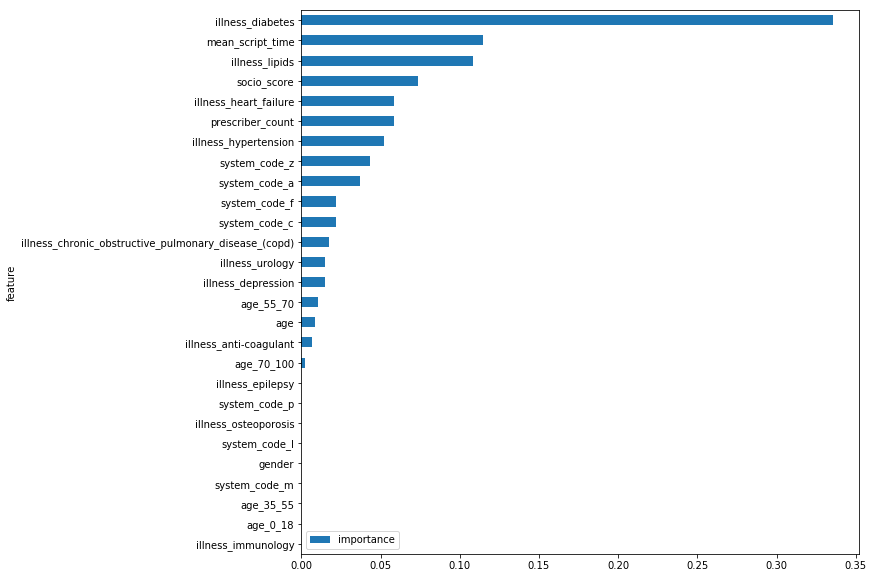

In [32]:
labels = [x for x in feature_frame.columns if 'target' not in x]
importance = pd.DataFrame([(x,y) for x, y in zip(labels, model.feature_importances_)], columns=['feature', 'importance'])
importance.sort_values('importance', ascending=True).set_index('feature').plot(kind='barh', figsize=(10,10))

In [66]:
from imblearn.ensemble import BalanceCascade
from sklearn.ensemble import VotingClassifier

# Apply Balance Cascade method
bc = BalanceCascade(estimator='gradient-boosting')
X_resampled, y_resampled = bc.fit_sample(X_train, y_train)

models = [('clf_{}'.format(i), 
           xgboost.XGBClassifier().fit(x, y)) 
              for i, x, y in zip(range(len(X_resampled)), X_resampled, y_resampled)]

models += [('svm_{}'.format(i), 
           SVC(probability=True, class_weight='balanced').fit(x, y)) 
              for i, x, y in zip(range(len(X_resampled)), X_resampled, y_resampled)]
    
    
    
clf = VotingClassifier(models, voting='soft')
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test) 

print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.97      0.96      4064
          1       0.86      0.81      0.83       936

avg / total       0.94      0.94      0.94      5000



## Form a submission

Perform the prediction in 1000 patient "chunks" to speed up the processing.

In [ ]:
model = xgboost.XGBClassifier().fit(X, y)

In [ ]:
submission = pd.read_csv('../submissions/diabetes_submission_example.csv')

In [ ]:
chunks = submission.groupby(np.arange(len(submission)) // 1000)

In [ ]:
for group, frame in tqdm.tqdm_notebook(chunks):
    
    # Extract the features
    data = [feature_extract(fast_retrieve_patient_data(conn, x)) for x in frame.Patient_ID.values]
    
    # Construct prediction X matrix
    features = pd.DataFrame(data)
    pred_x = features.drop('target', axis=1).values
    pred_x[np.isnan(pred_x)] = 0.0
    
    # Apply the standard transform prior to fitting. 
    pred_x = StandardScaler().fit_transform(pred_x)
    
    # Fit the model
    submission.Diabetes[frame.index] = model.predict_proba(pred_x)[:, 0]

In [ ]:
submission.to_csv('../submissions/kaggle_three.csv', index=False)